In [10]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.linalg import norm
from itertools import combinations

from plotter import *
from easyesn.optimizers import GradientOptimizer
from easyesn import PredictionESN
from easyesn import BaseESN
# note: you must make this change in the easyesn code
# https://github.com/kalekiu/easyesn/issues/12
from easyesn.optimizers import GridSearchOptimizer
from easyesn import helper as hlp

%matplotlib inline

""" NOTES:
    This file provides mechanisms to:
    A) Data Processing
        1) Load trajectories from csv files ( file must contain columns 'x', 'y')
        2) Create a trajectory from a trajectory generator (see more documentation in respective function)
        3) Load a generator from a csv file
        4) Load a set of feeders from a csv file
        5) Generate a matrix of place cell activations (row=place cell, column=time_index) 
           pc activation computed according to following formula:
                 e^( log(K) * ||pos - pc_center||^2 / r^2  )
           where 
                r is the place cell's radius
                K is the place cell's activation value at the radius
    
    B) Plot data
        Imports functionalities from 'plotter.py' which uses library matplotlib
"""


# CONSTANTS
PC_VALUE_AT_RADIUS = 0.8  # 0.2 activation value (constant K in pc activation formula)

def list_files(folder, extension=""):
    """ lost all files in the folder with the given extension
    """
    return sorted([ f for f in os.listdir(folder) if f.endswith(extension)])

def pad_single_sequence(s, length):
    """ Pads a dataframe so that it has the given length.
        we expect len(s) < length, if so, the first element is repeated as necessary.
    """
    pad_vectors = [ s.loc[[0]] ] * (length - len(s))
    return pd.concat([* pad_vectors , s]).reset_index(drop=True)

def pad_all_sequences(sequences):
    """
        Pads all sequences so that they have the same number of elements.
        Padding is added by repeating the first element as necessary
    """
    longest = max([ len(s) for s in sequences.values() ])
    return { k : pad_single_sequence(s, longest) for k, s in sequences.items() }

def calculate_sequence_mean_displacement(sequence):
    """
        Calculates the mean distance between consecutive points in the sequence.
    """
    num_data = len(sequence)
    displacements = sequence.loc[0:(num_data-2)].reset_index(drop=True) - sequence.loc[1:(num_data-1)].reset_index(drop=True)    
    return norm(displacements, axis=1).mean()

def load_path(file_name):
    """" load csv fle specifying a path
         file must contain at least columns 'x' and 'y'
    """
    return pd.read_csv(file_name, delim_whitespace=True)
    # return sequence[['x', 'y']].to_numpy()


def load_generator(file_name):
    """" load csv fle specifying a path generator
             file must contain at least columns 'x', 'y' and 'steps'
        """
    return pd.read_csv(file_name, delim_whitespace=True)


def generate_path(generator):
    """ Generate a path using a generator
        'generator' is a pandas data frame containing at least 3 columns 'x' 'y' and 'steps'
        Column 'steps' indicate the number of step to reach the following way point (the
        value in the last row is ignored since it is the last point in the path)
    """

    # convert data to numpy arrays
    xy = generator[['x', 'y']].to_numpy()  # waypoints
    steps = generator['steps'].to_numpy()  #

    # interpolate each segment
    # endpoint=False will avoid repeating the last coordinate of each segment
    interpolator = lambda m_tuple: np.linspace(*m_tuple, endpoint=False)
    data = zip(xy[:-1], xy[1:], steps[:-1])
    path = np.concatenate(list(map(interpolator, data)) + [[xy[-1]]])
    return pd.DataFrame(path, columns=['x', 'y'])


def load_feeders(file_name):
    """"Function to load a set of feeders"""
    return pd.read_csv(file_name, delim_whitespace=True)[['x', 'y']]


def load_place_cells(file_name):
    """" Load csv fle specifying a set of place cells
         file must contain at least columns 'x', 'y' and 'placeradius'
    """
    return pd.read_csv(file_name, delim_whitespace=True)
    # return pcs[['x', 'y']].to_numpy(), pcs['placeradius'].to_numpy()


def calc_activation_matrix(path, pcs):
    """ Calculate a matrix containing the activation of all place cells for all times.
        Each row represents a place cell, while columns represent the time index.
        Both 'pos' and 'pcs' are data frames containing the path and the set of place cells.
    """
    # get number of pcs and position in path
    num_pcs = len(pcs)
    num_pos = len(path)

    # convert data to numpy to operate
    radii = pcs['placeradius'].to_numpy()
    pcs = pcs[['x', 'y']].to_numpy()
    pos = path[['x', 'y']].to_numpy()

    # replicate the position vector by the number of place cells for easy operations
    pos_tile = pos.reshape(1, -1, 2)
    pos_all = np.tile(pos_tile, (num_pcs, 1, 1))

    # replicate the place cells and radii by the number of positions for easy operations
    pcs_tile = pcs.reshape(-1, 1, 2)
    pcs_all = np.tile(pcs_tile, (1, num_pos, 1))
    radii_all = np.tile(radii.reshape((-1, 1)), (1, num_pos))

    # calculate the activations (see description of formula at the top of this file)
    delta = pos_all - pcs_all
    delta2 = (delta * delta).sum(2)
    r2 = radii_all * radii_all
    exponents = np.log(PC_VALUE_AT_RADIUS) * delta2 / r2
    activations = np.exp(exponents)
    return activations

def plot_reservoir_states(pcs, sequence, activations, save_name, compare_sequence = None, title='', output_folder=''):
    """
        Creates figures with two subplots.
        Left plot shows heatmap representing the activation of the sequence vs time.
        Right plot shows the place cells in space, and the sequence path.
        If a compare sequence is given, the right plot also includes a second sequence to compare to
    """
    # create ouput folder if it doesnt exist:
    make_dirs(output_folder)
    
    fig, axs = plt.subplots(1, 2 )
    fig.suptitle(title)
    f1 = axs[0]
    f2 = axs[1]
    f2.autoscale(enable=True)
    f2.set_aspect('equal')
    plot_activation_matrix_heatmap(activations, plot=f1)

    plot_place_cells(pcs, plot=f2)  # add place cells to figure
#    plot_maze(plot=f2)
    if compare_sequence is not None:
        plot_path(compare_sequence, plot=f2)
    plot_path(sequence, plot=f2)
#    plot_feeders(feeders, plot=f2, s=80, zorder=2)  # zorder can be used to move the layer up or down
    plt.savefig(output_folder + save_name, dpi = 1200)
    
    return fig
    # display(save_name, plt)
    # plt.show()


def cos_sim(v1, v2):
    """
        Returns the cosine similitude between two vectors
    """
    return np.dot(v1, v2) / (norm(v1) * norm(v2))


def create_and_train_reservoir(activations):
    """
        Creates and trains the reservoir network.
        Activation sequences is used as input and expected output of the network.
        Rows are expected to be place cells, while columns are expected to represent time indeces
    """
    
    # initialize random seed, and set reservoir dimensions
    np.random.seed(1)
    vectorDim = len(activations) # reservoir input dimension
    numNode = 400   # number of reservoir nodes

    # create training input and output sets, augment it 2^10 times: 
    inputDataTraining = activations.T 
    outputDataTraining = activations.T
    print('activation shape:', activations.shape) 
    print('input data shape:', inputDataTraining.shape)

    # augment data by concatenating 2^10 times
    inputDataTraining = np.concatenate( [ inputDataTraining ] * 1024, axis = 0 )
    outputDataTraining=inputDataTraining
    print('augmented data shape:', inputDataTraining.shape)

    # create and train network: 
    esn = PredictionESN(n_input=vectorDim, n_output=vectorDim, n_reservoir=numNode, leakingRate=0.2, regressionParameters=[1e-2], solver="lsqr", feedback=False)
    esn.fit(inputDataTraining, outputDataTraining, transientTime="Auto", verbose=1)
    return esn

def predict_reservoir(trained_reservoir, activations):
    """
        Uses the trained reservoir to predict using the activations as input
        Activations should be a matrix with rows indicating pcs and columns indicating time
        Resturns only the last few states
    """
    prediction, reservoirStatesBuffer = trained_reservoir.predict(activations.T)
    print(reservoirStatesBuffer.shape)
    return prediction, reservoirStatesBuffer[257:,:].T


def plot_reservoir_states_Y_simplified(activations1, activations2, cos_sim_states, cos_sim_inputs, reservoir_states1, reservoir_states_2, save_name_suffix, plot_title, output_folder):
    """
        Generates a plot with 6 subplots
    """
    
    
    fig= plt.figure(figsize=(10,10))
    fig.suptitle(plot_title)
    #fig.suptitle('State Trajectories', fontsize=16)
    #fig.suptitle('State Trajectories')

    plt.subplot(321)
    plt.title('Input Temporal Structure 1')
    #plt.plot( inputDataTesting[:76,:])
    #sns.heatmap(activations, cmap="seismic")
    sns.heatmap(activations1)
    #plt.ylim([-1.1,1])
    
    plt.subplot(323)
    plt.title('Input Temporal Structure 2')
    #plt.plot( inputDataTesting2[:76,:])
    #sns.heatmap(activations2, vmin=0.4, vmax=1)
    sns.heatmap(activations2)
    #plt.ylim([-1.1,1])
   


    plt.subplot(325)
    plt.title('Inputs Cosine Similarity')
    plt.plot( cos_sim_inputs)
    plt.ylim([0,1.1])

    plt.subplot(326)
    plt.title('Reservoir States Cosine Similarity')
    plt.plot( cos_sim_states )
    plt.ylim([0,1.1])


    # Following we plot the reservoir temporal structure, we can simplify printing only the first 10 states
    resn = 10
    plt.subplot(322)
    plt.title('Reservoir States Temporal Structure 1')
    plt.plot( reservoir_states1[:,:resn])
    #plt.plot( inputDataTestingA[:,:5])
    plt.ylim([-1.1,1])
    
    plt.subplot(324)
    plt.title('Reservoir States Temporal Structure 2')
    plt.plot( reservoir_states_2[:,:resn])
    #plt.plot( inputDataTestingB[:,:5])
    plt.ylim([-1.1,1])
    

    fig.tight_layout()
    plt.savefig(output_folder + f'reservoirstates-Y-simplified{save_name_suffix}.png')
    return fig

def plot_can_reservoir_distinguish_sequences(activations1, activations2, save_suffix, plot_title='', output_folder=''):
    """
        trains a reservoir network and outpus a figure showing the similitude between inputs,
        and the similitude between reservoir states, additionally the plot shows both inputs and reservoir states in time
    """
    
    # create ouput folder if it doesnt exist:
    make_dirs(output_folder)
    
    # create and train the reservoir using first set of activations
    esn = create_and_train_reservoir(activations1)

    # predict and get reservoir states for both sets of activations
    _, reservoir_states1 = predict_reservoir(esn, activations1)
    _, reservoir_states2 = predict_reservoir(esn, activations2)

    # calculate cosine similitude between inputs and between reservoir states
    cos_sim_inputs = [ cos_sim(d1, d2) for (d1, d2) in zip(activations1.T, activations2.T)]
    cos_sim_states = [ cos_sim(s1, s2) for (s1, s2) in zip(reservoir_states1, reservoir_states2) ]
    
    # plot the results
    return plot_reservoir_states_Y_simplified(activations1, activations2, cos_sim_states, cos_sim_inputs, reservoir_states1, reservoir_states2, save_suffix, plot_title, output_folder)    

def make_dirs(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)


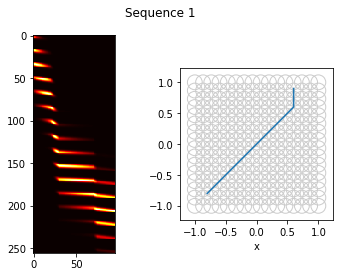

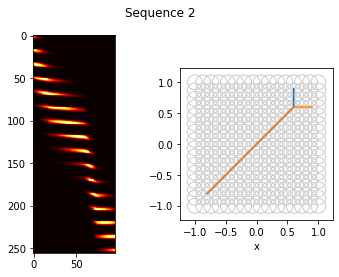

activation shape: (256, 96)
input data shape: (96, 256)
augmented data shape: (98304, 256)


100% (98200 of 98200) |##################| Elapsed Time: 0:00:19 Time:  0:00:19


(657, 96)
(657, 96)


<module 'matplotlib.pylab' from 'c:\\users\\bucef\\appdata\\local\\programs\\python\\python39\\lib\\site-packages\\matplotlib\\pylab.py'>

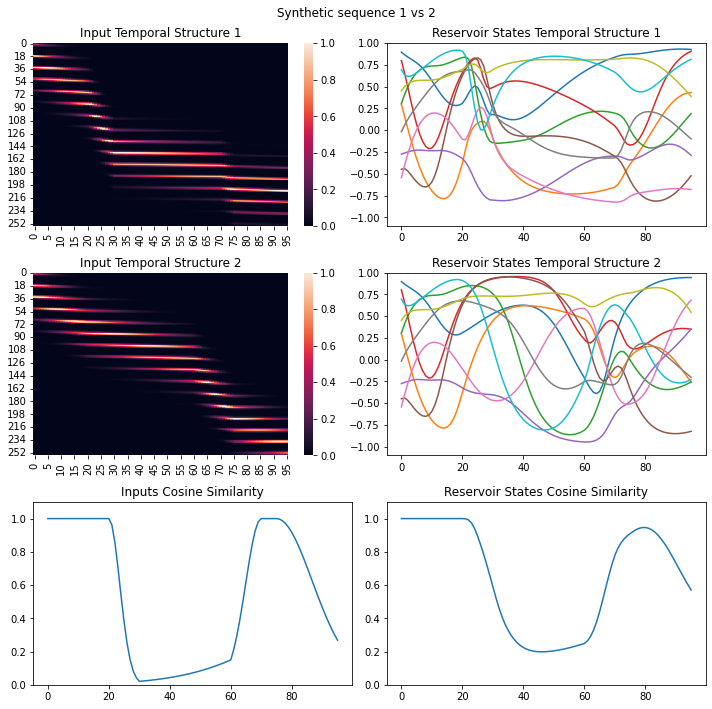

In [11]:
    # test load place cells and a trajectory
    pcs = load_place_cells('input/placecells.csv')
    abcde = load_path('input/abcde.csv')
    feeders = load_feeders('input/feeders.csv')

    # test load generator and generate path using 'sample_path_generator.csv':
    # the generator is a sequence of way points
    # 'steps' indicate the number of steps to reach the next way point
    # note: the number of steps in the last row is ignored
    #   x     |  y     | steps
    # ------------------------
    #   -0.4  |  -0.4  |   7
    #    0    |   0    |  10
    #    0.5  |   0    |  -1

    # note: alternatively you can generate the data like this:
    # sample_generator = pd.DataFrame({'x':     [-0.4,  0,  0.5],
    #                                  'y':     [-0.4,  0,  0  ],
    #                                  'steps': [ 7  , 10, -1  ]})
    
    #modifying to allow two sequences
#    sample_generator = load_generator('input/sample_path_generator.csv')
#    sample_generator2 = load_generator('input/sample_path_generator2.csv')
    sample_generator1 = load_generator('input/path-y-a')
    sample_generator2 = load_generator('input/path-y-b')
    generated_path1 = generate_path(sample_generator1)
    generated_path2 = generate_path(sample_generator2)
    # display(generated_path, generated_path2)

    # test calculation of activation matrix
    # choose sequence: 'generated_path' or 'abcde'
    sequence1 = generated_path1
    sequence2 = generated_path2
    
    activations1 = calc_activation_matrix(sequence1, pcs)
    activations2 = calc_activation_matrix(sequence2, pcs)

    
    # test plot utilities
    save_folder = 'images/'
    plot_reservoir_states(pcs, sequence1, activations1, 'reservoirstates-Y-left.png', title = 'Sequence 1', output_folder = save_folder)
    plt.show()
    plot_reservoir_states(pcs, sequence2, activations2, 'reservoirstates-Y-right.png', sequence1, title = 'Sequence 2', output_folder = save_folder)
    plt.show()

    plot_can_reservoir_distinguish_sequences(activations1, activations2, '', 'Synthetic sequence 1 vs 2', save_folder)
    display(plt)


{'fss_0': 0.10172203909764774,
 'fss_1': 0.10024876655448742,
 'kkk_0': 0.1037335119470402,
 'kkk_1': 0.10272399158152683,
 'sfs_0': 0.10098300073848074,
 'sfs_1': 0.10472721395373853}

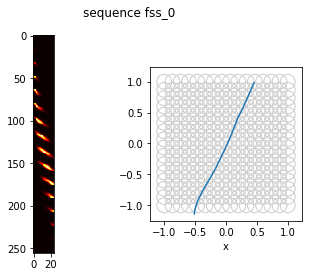

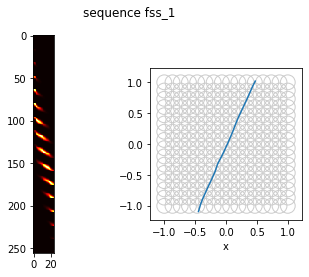

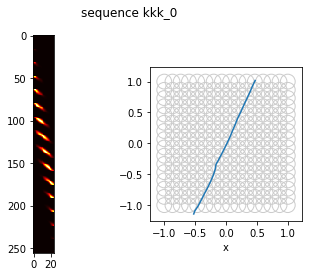

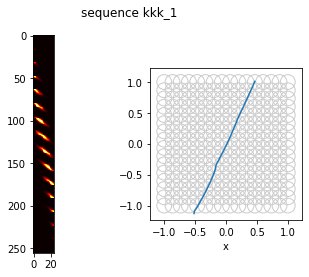

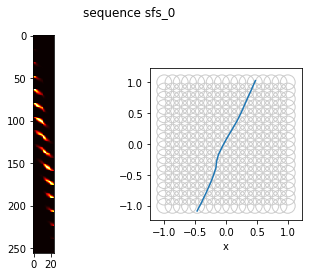

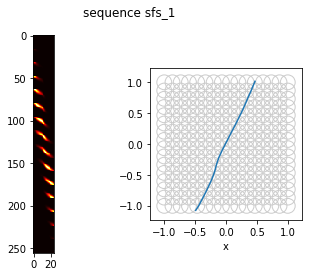

activation shape: (256, 24)
input data shape: (24, 256)
augmented data shape: (24576, 256)


100% (24469 of 24469) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


(657, 24)
(657, 24)


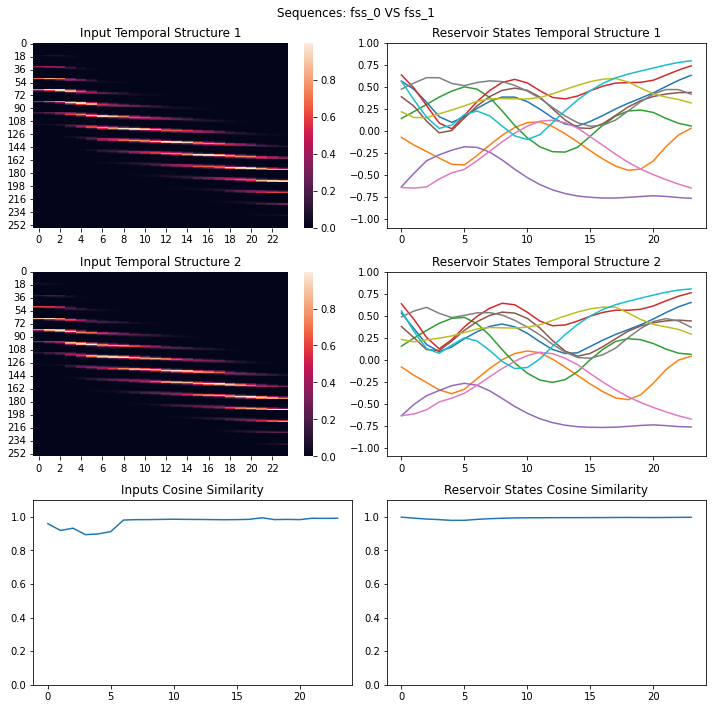

activation shape: (256, 24)
input data shape: (24, 256)
augmented data shape: (24576, 256)


100% (24469 of 24469) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


(657, 24)
(657, 24)


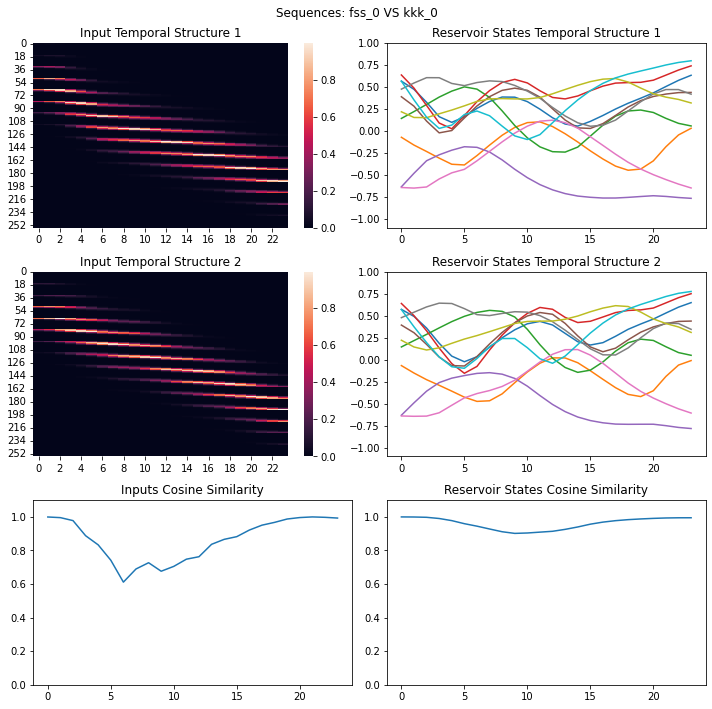

activation shape: (256, 24)
input data shape: (24, 256)
augmented data shape: (24576, 256)


100% (24469 of 24469) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


(657, 24)
(657, 24)


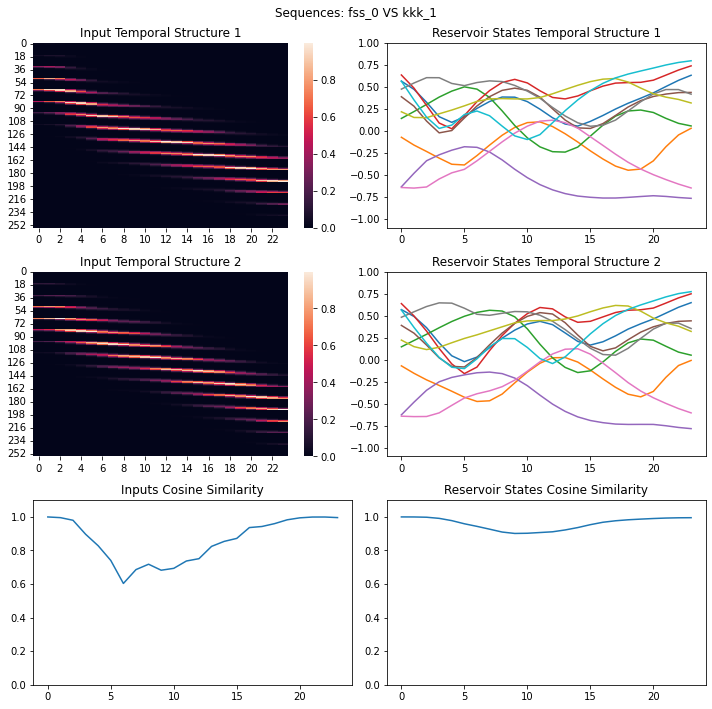

activation shape: (256, 24)
input data shape: (24, 256)
augmented data shape: (24576, 256)


100% (24469 of 24469) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


(657, 24)
(657, 24)


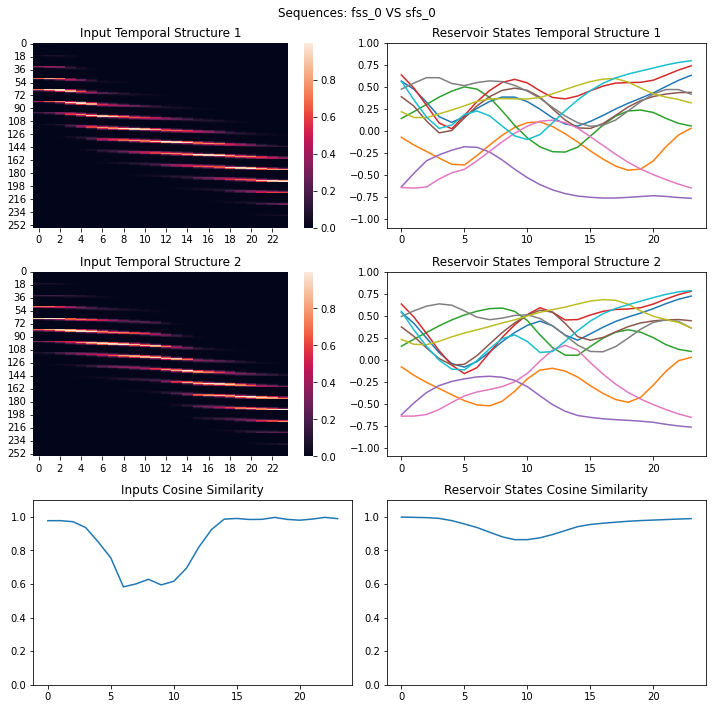

activation shape: (256, 24)
input data shape: (24, 256)
augmented data shape: (24576, 256)


100% (24469 of 24469) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


(657, 24)
(657, 24)


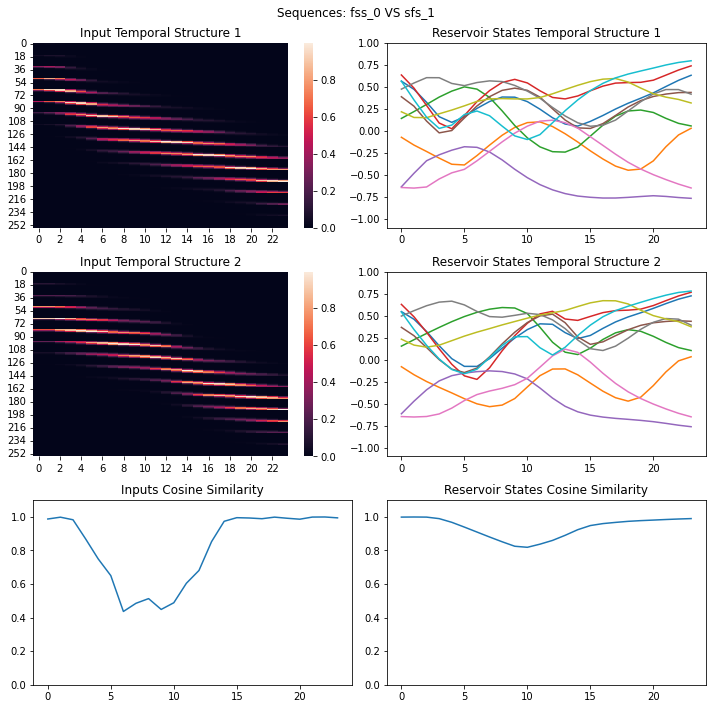

activation shape: (256, 24)
input data shape: (24, 256)
augmented data shape: (24576, 256)


100% (24470 of 24470) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


(657, 24)
(657, 24)


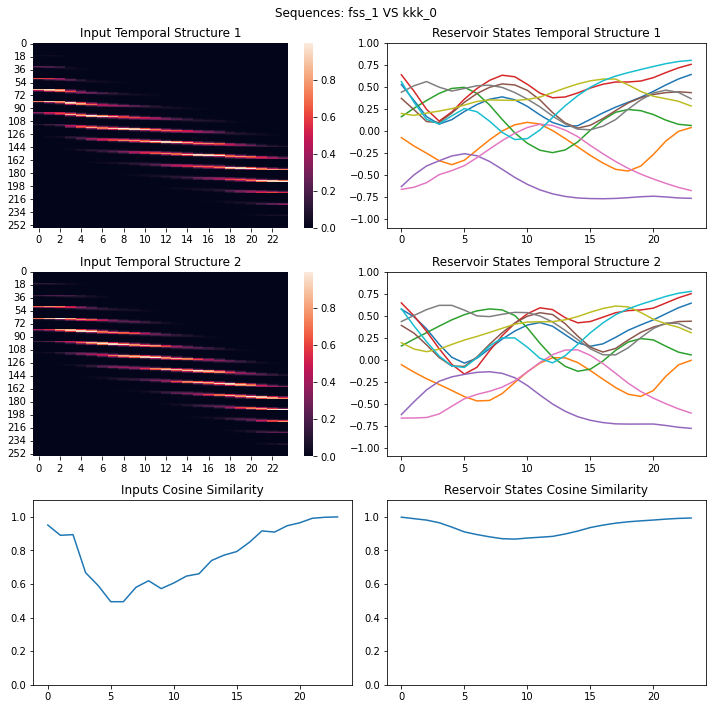

activation shape: (256, 24)
input data shape: (24, 256)
augmented data shape: (24576, 256)


100% (24470 of 24470) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


(657, 24)
(657, 24)


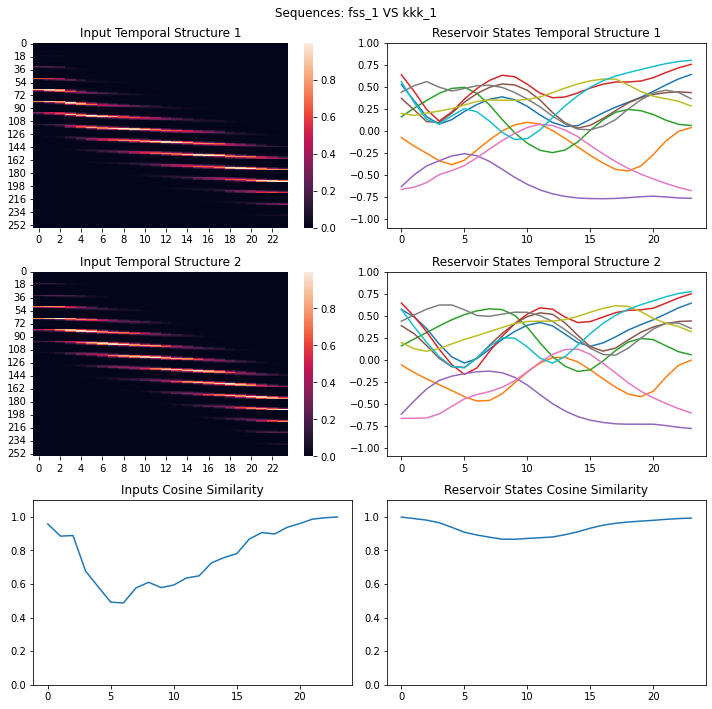

activation shape: (256, 24)
input data shape: (24, 256)
augmented data shape: (24576, 256)


100% (24470 of 24470) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


(657, 24)
(657, 24)


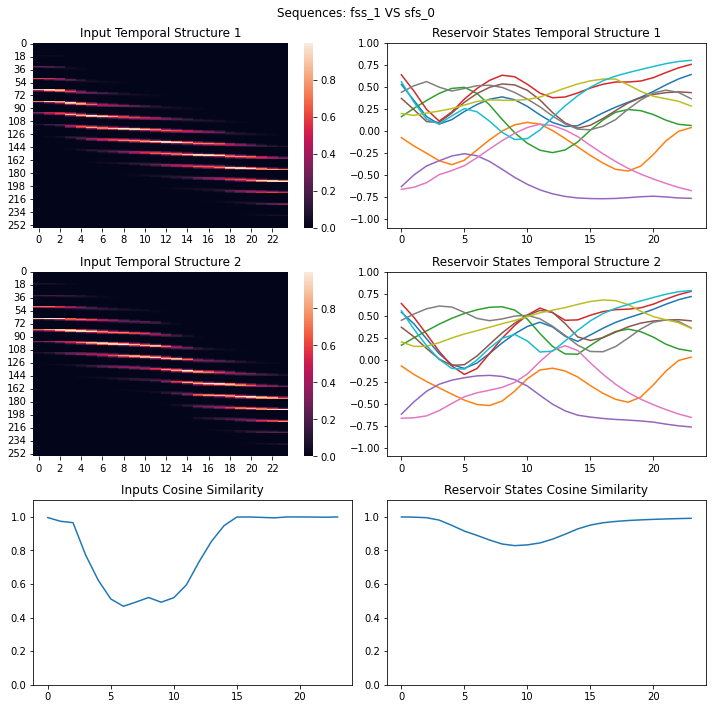

activation shape: (256, 24)
input data shape: (24, 256)
augmented data shape: (24576, 256)


100% (24470 of 24470) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


In [ ]:
# load sequences from robot experiment, add poadding as necessary
input_folder = 'input/robot_recordings/'  
sequence_files = list_files(input_folder, '.csv')
sequences = { f[-9:-4] : pd.read_csv(input_folder + f)[['x','y']].copy()  for f in sequence_files }
padded_sequences = pad_all_sequences(sequences)

# calculate mean distances and pc activations for each sequence:
robot_mean_distances = { k : calculate_sequence_mean_displacement(s) for k, s in sequences.items()} # need to use unpadded sequences, else averages extra zeros
robot_activations = { k : calc_activation_matrix(s, pcs) for k, s in padded_sequences.items()}
display(robot_mean_distances)

save_folder = 'images/robot_experiment/'
for k , s in padded_sequences.items():
    plot_reservoir_states(pcs, s, robot_activations[k], f'input_data-{k}.png', title = f'sequence {k}', output_folder = save_folder)
    plt.show()
    
for (k1, k2) in combinations( sequences.keys(), 2):
    plot_can_reservoir_distinguish_sequences(robot_activations[k1], robot_activations[k2] , f'_{k1}_VS_{k2}', f'Sequences: {k1} VS {k2}', save_folder)
    plt.show()
